In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from google.colab import drive
drive.mount('/content/gdrive')

# Load the data
data = pd.read_excel('/content/gdrive/My Drive/dataset.xlsx', parse_dates=['Datetime'], index_col='Datetime')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Check for duplicate timestamps
duplicates = data.index.duplicated()
if duplicates.any():
    print("Duplicates found:", data.index[duplicates])
else:
    print("No duplicates found.")

Duplicates found: DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)


In [ ]:
# Aggregate data by taking the mean for each hour if duplicates are found
data = data.groupby(data.index).mean()

In [ ]:
# Basic descriptive statistics
print(data.describe())

Q1 = data['PJME_MW'].quantile(0.25)
Q3 = data['PJME_MW'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['PJME_MW'] >= lower_bound) & (data['PJME_MW'] <= upper_bound)]
print()
print(data.describe())

             PJME_MW
count  145362.000000
mean    32080.507722
std      6463.870519
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000

             PJME_MW
count  141907.000000
mean    31616.632996
std      5789.304838
min     15526.000000
25%     27461.000000
50%     31266.000000
75%     35248.500000
max     47765.000000


In [ ]:
# Set the expected frequency to hourly
data = data.asfreq('H')

# Recount missing values after ensuring hourly frequency
missing_values_count = data['PJME_MW'].isnull().sum()
print(f"Number of missing values in 'PJME_MW' after setting hourly frequency: {missing_values_count}")

Number of missing values in 'PJME_MW' after setting hourly frequency: 3485


In [ ]:
# linear interpolation for missing values
data['PJME_MW'] = data['PJME_MW'].interpolate(method='linear')

# Recount missing values after ensuring hourly frequency
missing_values_count = data['PJME_MW'].isnull().sum()
print(f"Number of missing values in 'PJME_MW' after setting hourly frequency: {missing_values_count}")

Number of missing values in 'PJME_MW' after setting hourly frequency: 0


Skewness:  0.4616981486871183
Kurtosis:  -0.2036298381480175


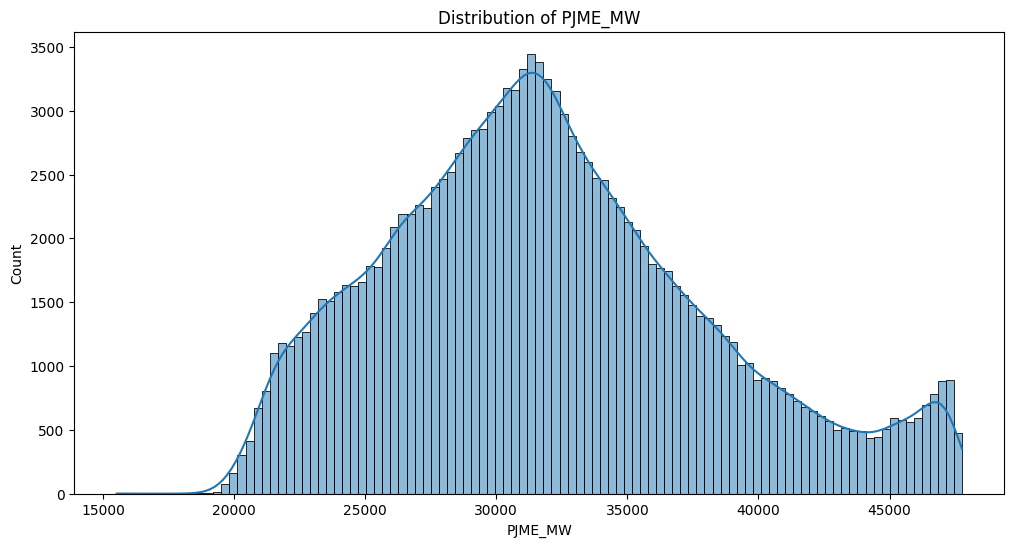

In [ ]:
# Skewness and Kurtosis
print("Skewness: ", data['PJME_MW'].skew())
print("Kurtosis: ", data['PJME_MW'].kurt())

# Histogram and density plot
plt.figure(figsize=(12, 6))
sns.histplot(data['PJME_MW'], kde=True)
plt.title('Distribution of PJME_MW')
plt.show()

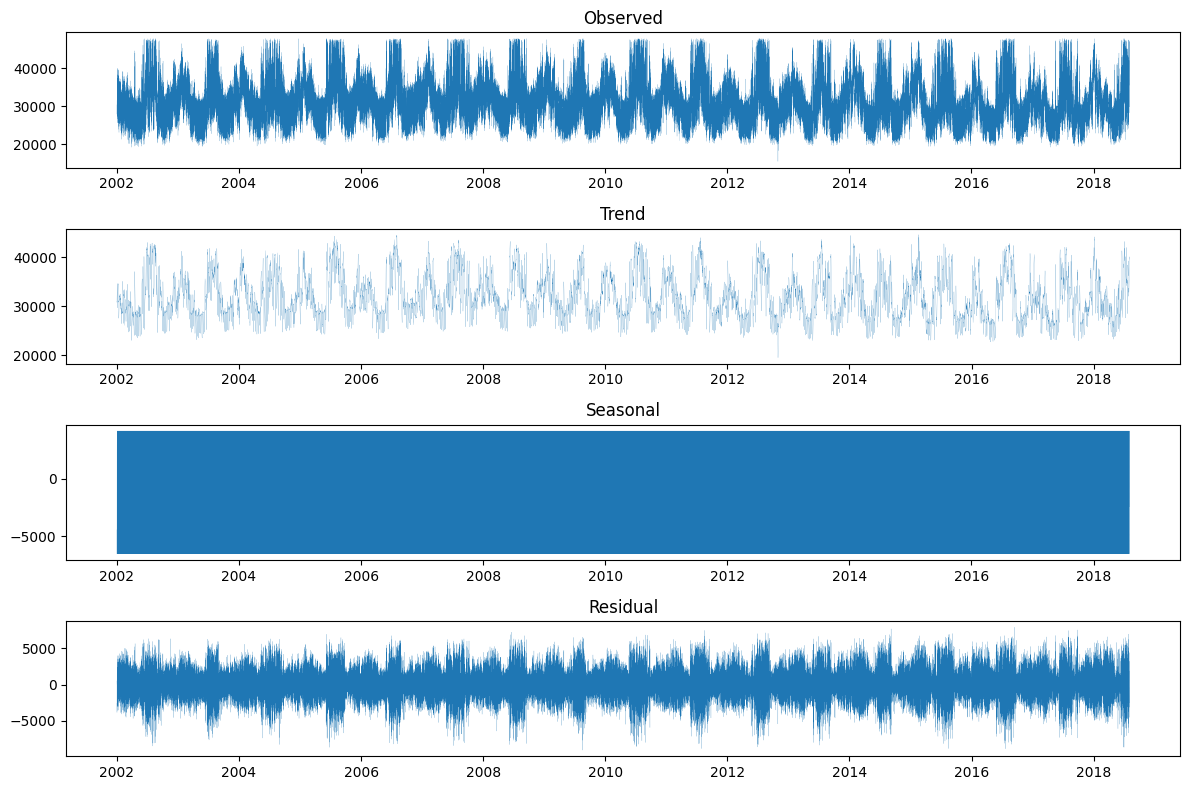

In [ ]:
# Assuming 'data' is your DataFrame indexed by DateTime and 'PJME_MW' is the time series column
decomposition = seasonal_decompose(data['PJME_MW'], model='additive')

# Decompose and get the result
# result = decomposition.plot()

# Manually adjust the plots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

# Plot each component with adjusted line width
ax1.plot(decomposition.observed, linewidth=0.1)
ax1.set_title('Observed', fontsize=12)

ax2.plot(decomposition.trend, linewidth=0.1)
ax2.set_title('Trend', fontsize=12)

ax3.plot(decomposition.seasonal, linewidth=0.1)
ax3.set_title('Seasonal', fontsize=12)

ax4.plot(decomposition.resid, linewidth=0.1)
ax4.set_title('Residual', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


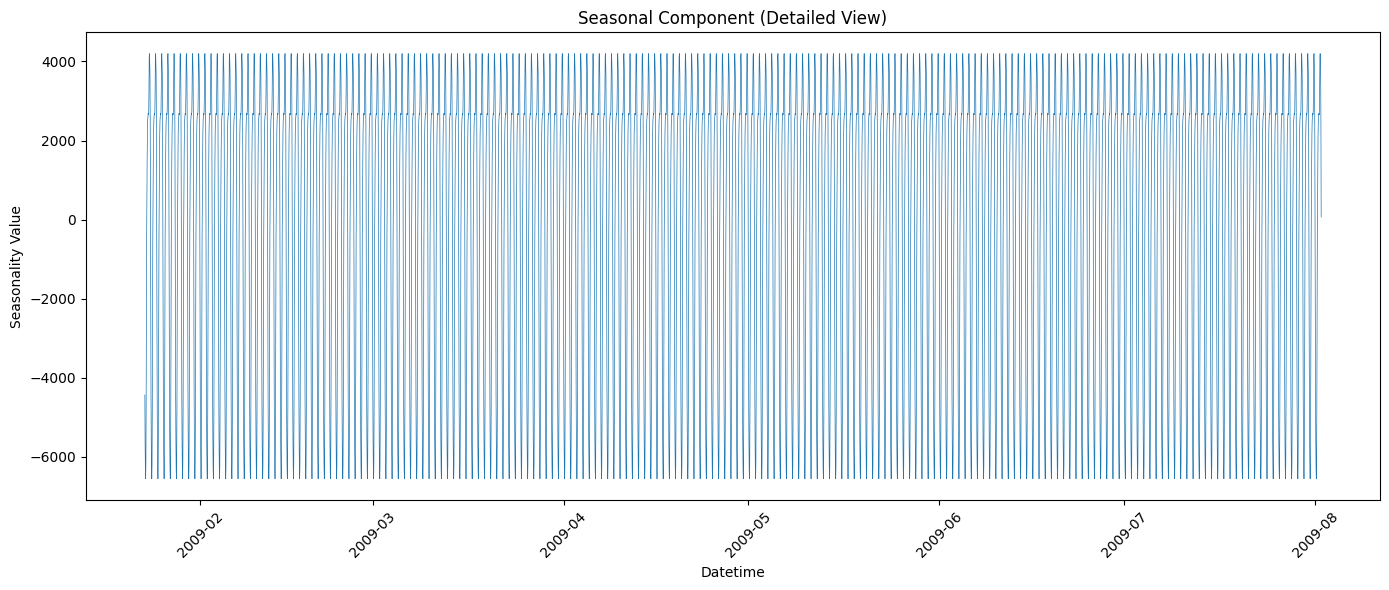

In [ ]:
# The seasonality aptterns are not visible in the above plot
# Choose a specific period to focus on. Here, we'll look at the first 14 days which is 14*24 hours
# Adjust the slice according to your data index and the specific period you are interested in

# Select a two-week slice for closer inspection
seasonal_component = decomposition.seasonal['23-01-2009  01:00:00':'08-01-2009  23:00:00']

plt.figure(figsize=(14, 6))
plt.plot(seasonal_component, linewidth=0.5)
plt.title('Seasonal Component (Detailed View)')
plt.xlabel('Datetime')
plt.ylabel('Seasonality Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit the x-axis labels
plt.show()


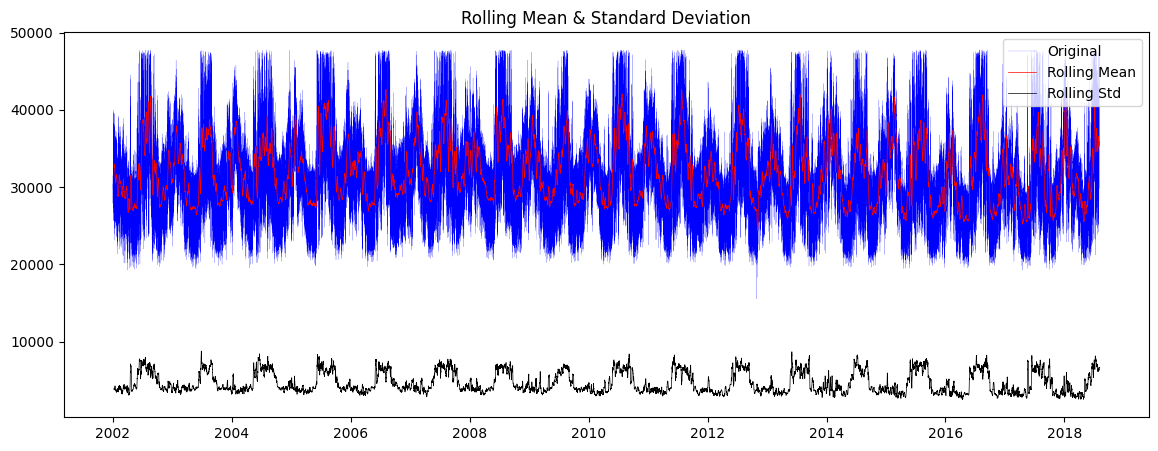

In [ ]:
# Check for stationarity
# Calculate rolling statistics
rolling_mean = data['PJME_MW'].rolling(window=24*7).mean()  # 1-week rolling mean
rolling_std = data['PJME_MW'].rolling(window=24*7).std()  # 1-week rolling standard deviation

# Plot rolling statistics
plt.figure(figsize=(14, 5))
plt.plot(data['PJME_MW'], color='blue', label='Original', linewidth=0.1)
plt.plot(rolling_mean, color='red', label='Rolling Mean', linewidth=0.5)
plt.plot(rolling_std, color='black', label='Rolling Std', linewidth=0.5)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
# Perform Dickey-Fuller test
adf_result = adfuller(data['PJME_MW'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Check p-value
if adf_result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")


ADF Statistic: -20.017288
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
The time series is stationary.


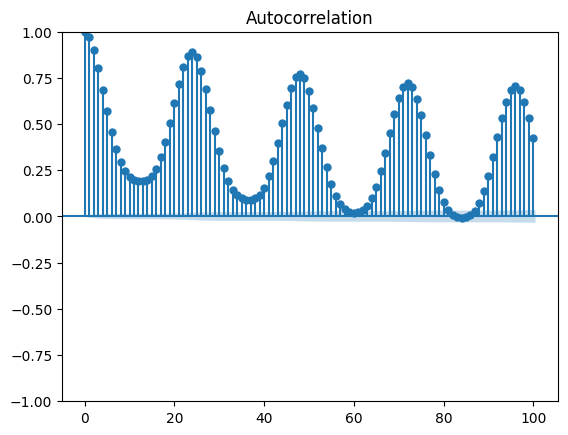

The minimum y-value is -0.006939261471979907 at lag 84.


In [ ]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plot ACF
plot_acf(data['PJME_MW'], lags=100)  # Plot first 100 lags to start
plt.show()

# Calculate ACF values for the first 100 lags
acf_values = acf(data['PJME_MW'], nlags=100)

# Find the lag where the ACF is minimum
min_acf_value = min(acf_values)
min_acf_lag = acf_values.tolist().index(min_acf_value)

print(f"The minimum y-value is {min_acf_value} at lag {min_acf_lag}.")

# Use ACF and PACF plots to inform your decision on lag length.
# Then use statistical tests with this lag length.

# Look for the point at which the autocorrelations in the ACF/PACF plots drop off and become insignificant.
# A common heuristic is to look for the 'elbow' in these plots—the point where the correlation coefficients drop and then hover around zero.

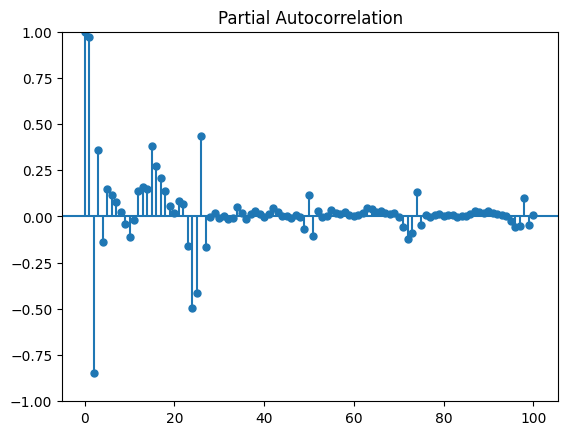

The minimum y-value is -0.8474932190298166 at lag 2.


In [ ]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Plot PACF
plot_pacf(data['PJME_MW'], lags=100)  # Plot first 100 lags to start
plt.show()

# Calculate PACF values for the first 100 lags
pacf_values = pacf(data['PJME_MW'], nlags=100)

# Find the lag where the PACF is minimum
min_pacf_value = min(pacf_values)
min_pacf_lag = pacf_values.tolist().index(min_pacf_value)

print(f"The minimum y-value is {min_pacf_value} at lag {min_pacf_lag}.")

# Use ACF and PACF plots to inform your decision on lag length.
# Then use statistical tests with this lag length.

# Look for the point at which the autocorrelations in the ACF/PACF plots drop off and become insignificant.
# A common heuristic is to look for the 'elbow' in these plots—the point where the correlation coefficients drop and then hover around zero.

In [ ]:
# Normalization for Neural Nets
data['PJME_MW_normalized'] = (data['PJME_MW'] - data['PJME_MW'].min()) / (data['PJME_MW'].max() - data['PJME_MW'].min())

# Basic descriptive statistics
print(data.describe())

             PJME_MW  PJME_MW_normalized
count  145392.000000       145392.000000
mean    31967.251073            0.509980
std      6153.686544            0.190877
min     15526.000000            0.000000
25%     27571.000000            0.373616
50%     31420.000000            0.493005
75%     35647.000000            0.624120
max     47765.000000            1.000000


In [ ]:
data.to_excel('/content/gdrive/My Drive/processed_dataset.xlsx')

In [ ]:
# Load the data
proc_data = pd.read_excel('/content/gdrive/My Drive/processed_dataset.xlsx', parse_dates=['Datetime'], index_col='Datetime')

In [ ]:
# Check for duplicate timestamps
duplicates = proc_data.index.duplicated()
if duplicates.any():
    print("Duplicates found:", proc_data.index[duplicates])
else:
    print("No duplicates found.")

# Aggregate data by taking the mean for each hour if duplicates are found
proc_data = proc_data.groupby(data.index).mean()

# Set the expected frequency to hourly
proc_data = proc_data.asfreq('H')

# Recount missing values after ensuring hourly frequency
missing_values_count = proc_data['PJME_MW_normalized'].isnull().sum()
print(f"Number of missing values in 'PJME_MW_normalized' after setting hourly frequency: {missing_values_count}")

No duplicates found.
Number of missing values in 'PJME_MW_normalized' after setting hourly frequency: 0
